In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Cluster Por Musicas").getOrCreate()
df = spark.read.csv('dados_musicas.csv', header=True, inferSchema=True, sep=';')
df.show(2)

+-------+----+------------+--------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-----------+----------+-----------+-------+--------------------+
|valence|year|acousticness| artists|danceability|duration_ms|            energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|       name|popularity|speechiness|  tempo|        artists_song|
+-------+----+------------+--------+------------+-----------+------------------+--------+--------------------+----------------+---+--------+-------------------+----+-----------+----------+-----------+-------+--------------------+
|  0.285|2000|     0.00239|Coldplay|       0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|         1.21E-4| 11|   0.234|             -7.227|   1|     Yellow|        84|     0.0281|173.372|   Coldplay - Yellow|
|  0.613|2000|       0.143| OutKast|       0.843|     270507|0.8059999999999999|

In [3]:
X = df.columns
X.remove('artists')
X.remove('id')
X.remove('name')
X.remove('artists_song')
X


['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

In [6]:
from pyspark.ml.feature import VectorAssembler
dados_encoded = VectorAssembler(inputCols=X,outputCol='features').transform(df)
dados_encoded.select('features').show(2,truncate=False)

+-------------------------------------------------------------------------------------------------------------------+
|features                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------+
|[0.285,2000.0,0.00239,0.429,266773.0,0.6609999999999999,0.0,1.21E-4,11.0,0.234,-7.227,1.0,84.0,0.0281,173.372]     |
|[0.613,2000.0,0.143,0.843,270507.0,0.8059999999999999,1.0,0.0,4.0,0.0771,-5.9460000000000015,0.0,80.0,0.269,94.948]|
+-------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [9]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features',outputCol='features_scaled')
fited = scaler.fit(dados_encoded)
transformed = fited.transform(dados_encoded)
transformed.select('features_scaled').show(2,truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.156596679221045,329.8170613984441,0.008403188822334736,2.5040545743834373,3.7858811737298526,2.980511298201045,0.0,6.070790766862789E-4,3.0696424994844875,1.4832857988766257,-1.

In [10]:
K = len(X)
K

15

In [12]:
from pyspark.ml.feature import PCA
pca = PCA(k=15, inputCol='features_scaled', outputCol='pca_features')
fited_pca = pca.fit(transformed)
tansformed_pca = fited_pca.transform(transformed)

In [15]:
tansformed_pca.select('pca_features').show(2,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                                                                                                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775706,-165.3684878490618,-11.163498729832531,-139.11374280854452,14.152192300931285,-6.254422223810332,-42.69458485

In [16]:
fited_pca.explainedVariance

DenseVector([0.213, 0.133, 0.0939, 0.0869, 0.0733, 0.0665, 0.0616, 0.0563, 0.0505, 0.0462, 0.0339, 0.0284, 0.0264, 0.0202, 0.0099])

In [19]:
sum(fited_pca.explainedVariance) * 100

100.00000000000004

In [21]:
lista_valores = [sum(fited_pca.explainedVariance[0:i+1]) for i in range(K)]
lista_valores

[0.21297354127107346,
 0.3459774162295507,
 0.43989805678254457,
 0.5267820578269105,
 0.6001038103117929,
 0.666571951365239,
 0.7282174213581728,
 0.7845103843321024,
 0.8350002357002615,
 0.8812446547406771,
 0.9151737562703051,
 0.9435370133056041,
 0.9699018569070164,
 0.9900947792885583,
 1.0000000000000004]

In [25]:
import numpy as np
k = sum(np.array(lista_valores) < 0.7)
k

6

In [39]:
pca = PCA(k=6, inputCol='features_scaled', outputCol='pca_features')
fited_pca_2 = pca.fit(transformed)
tansformed_pca_final = fited_pca_2.transform(transformed)

In [35]:
tansformed_pca_final.select("pca_features").show(2,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775706,-165.3684878490618,-11.163498729832531,-139.11374280854452,14.152192300931285,-6.254422223810332]  |
|[-36.49885762774909,-167.85185045616552,-10.729023248906778,-135.90435265671317,13.388401890587135,-3.9729807278308047]|
+-----------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [40]:
sum(fited_pca_2.explainedVariance) * 100

66.6571951365239

In [42]:
from pyspark.ml import Pipeline
pca_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=X,outputCol='features'),
    StandardScaler(inputCol='features',outputCol='features_scaled'),
    PCA(k=6, inputCol='features_scaled', outputCol='pca_features')
])

In [43]:
model_pca_pipeline = pca_pipeline.fit(df)
projection = model_pca_pipeline.transform(df)


In [46]:
projection.select('pca_features').show(2,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775706,-165.3684878490618,-11.163498729832531,-139.11374280854452,14.152192300931285,-6.254422223810332]  |
|[-36.49885762774909,-167.85185045616552,-10.729023248906778,-135.90435265671317,13.388401890587135,-3.9729807278308047]|
+-----------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [47]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=50, featuresCol='pca_features')
fited = kmeans.fit(projection)
transformed = fited.transform(projection)

In [129]:
transformed.select('artists_song','prediction').show(100, truncate=False)

+----------------------------------------------------------------------------------+----------+
|artists_song                                                                      |prediction|
+----------------------------------------------------------------------------------+----------+
|Coldplay - Yellow                                                                 |37        |
|OutKast - Ms. Jackson                                                             |9         |
|Linkin Park - In the End                                                          |0         |
|3 Doors Down - Kryptonite                                                         |16        |
|Eminem - The Real Slim Shady                                                      |48        |
|Disturbed - Down with the Sickness                                                |48        |
|Nelly - Ride Wit Me                                                               |1         |
|Eminem - Stan                          

In [61]:
#Elbow Method
elbow_values = []
for K in range(2,50):
    kmeans = KMeans(k=K, featuresCol='pca_features')
    fited = kmeans.fit(projection)
    transformed = fited.transform(projection)
    elbow_values.append(fited.summary.trainingCost)


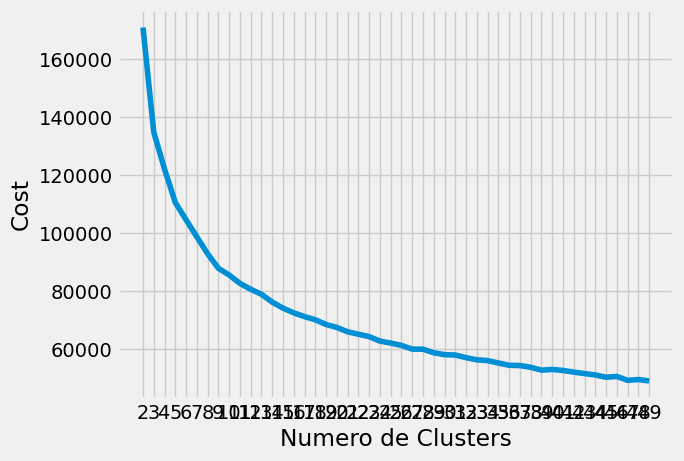

In [63]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(range(2,50),elbow_values)
plt.xticks(range(2,50))
plt.xlabel('Numero de Clusters')
plt.ylabel('Cost')
plt.show()

In [64]:
from kneed import KneeLocator
knee = KneeLocator(range(2,50), elbow_values, curve='convex', direction='decreasing')
knee.elbow

14

In [65]:
kmeans = KMeans(k=14, featuresCol='pca_features')
fited = kmeans.fit(projection)
transformed_optimal = fited.transform(projection)


In [66]:
from pyspark.ml.functions import vector_to_array
projection_optmal = transformed_optimal.withColumn('x', vector_to_array('pca_features')[0])\
                    .withColumn('y', vector_to_array('pca_features')[1])

In [67]:
projection_optmal.select(['x','y','prediction']).show(10)

+-------------------+-------------------+----------+
|                  x|                  y|prediction|
+-------------------+-------------------+----------+
| -34.71004464775706| -165.3684878490618|        10|
| -36.49885762774909|-167.85185045616552|         9|
| -35.46030091694059|-165.99633344577884|         6|
| -35.56301325520586|-165.59515096480604|         6|
|  -36.5455697490757| -167.3751250580248|         0|
| -36.71322229026236|-166.48208483099705|         9|
| -36.01324617882224|-166.63514920955342|         9|
|-36.542687712104936| -166.9792823483324|         9|
| -36.42524900978434|-165.10535006330755|         3|
| -35.87207491577076|-166.03098838247914|         3|
+-------------------+-------------------+----------+
only showing top 10 rows



In [72]:
projection_optmal.toPandas()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,popularity,speechiness,tempo,artists_song,features,features_scaled,pca_features,prediction,x,y
0,0.285,2000,0.00239,Coldplay,0.429,266773,0.661,0,3AJwUDP919kvQ9QcozQPxg,0.000121,...,84,0.0281,173.372,Coldplay - Yellow,"[0.285, 2000.0, 0.00239, 0.429, 266773.0, 0.66...","[1.156596679221045, 329.8170613984441, 0.00840...","[-34.71004464775706, -165.3684878490618, -11.1...",10,-34.710045,-165.368488
1,0.613,2000,0.14300,OutKast,0.843,270507,0.806,1,0I3q5fE6wg7LIfHGngUTnV,0.000000,...,80,0.2690,94.948,OutKast - Ms. Jackson,"[0.613, 2000.0, 0.143, 0.843, 270507.0, 0.8059...","[2.4876974188157917, 329.8170613984441, 0.5027...","[-36.49885762774909, -167.85185045616552, -10....",9,-36.498858,-167.851850
2,0.400,2000,0.00958,Linkin Park,0.556,216880,0.864,0,60a0Rd6pjrkxjPbaKzXjfq,0.000000,...,84,0.0584,105.143,Linkin Park - In the End,"[0.4, 2000.0, 0.00958, 0.556, 216880.0, 0.8640...","[1.6232935848716423, 329.8170613984441, 0.0336...","[-35.46030091694059, -165.99633344577884, -11....",6,-35.460301,-165.996333
3,0.543,2000,0.00664,3 Doors Down,0.545,233933,0.865,0,6ZOBP3NvffbU4SZcrnt1k6,0.000011,...,78,0.0286,99.009,3 Doors Down - Kryptonite,"[0.5429999999999999, 2000.0, 0.00664, 0.545, 2...","[2.203621041463254, 329.8170613984441, 0.02334...","[-35.56301325520586, -165.59515096480604, -11....",6,-35.563013,-165.595151
4,0.760,2000,0.03020,Eminem,0.949,284200,0.661,1,3yfqSUWxFvZELEM4PmlwIR,0.000000,...,80,0.0572,104.504,Eminem - The Real Slim Shady,"[0.76, 2000.0, 0.0302, 0.949, 284200.0, 0.6609...","[3.0842578112561205, 329.8170613984441, 0.1061...","[-36.5455697490757, -167.3751250580248, -11.88...",0,-36.545570,-167.375125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20306,0.187,2020,0.57400,Bazzi,0.445,176250,0.330,0,0PUkanqCGTb6qseXPKOw1F,0.000000,...,69,0.0429,128.025,Bazzi - I Don't Think I'm Okay,"[0.187, 2020.0, 0.574, 0.445, 176250.0, 0.33, ...","[0.7588897509274928, 333.1152320124285, 2.0181...","[-33.06646257511095, -167.90227534038993, -12....",1,-33.066463,-167.902275
20307,0.240,2020,0.81500,Bryson Tiller,0.467,179188,0.429,0,6Iw6fQVKZi0fWtEQBrTFcP,0.000052,...,65,0.0964,148.530,Bryson Tiller - Timeless Interlude,"[0.24, 2020.0, 0.815, 0.467, 179188.0, 0.429, ...","[0.9739761509229853, 333.1152320124285, 2.8655...","[-33.25250737401926, -168.0927830743737, -11.5...",1,-33.252507,-168.092783
20308,0.466,2020,0.31000,Fleet Foxes,0.562,253613,0.686,0,308prODCCD0O660tIktbUi,0.022500,...,66,0.0249,103.054,Fleet Foxes - Sunblind,"[0.466, 2020.0, 0.31, 0.562, 253613.0, 0.68599...","[1.8911370263754634, 333.1152320124285, 1.0899...","[-34.33830500625214, -167.07584728873724, -12....",12,-34.338305,-167.075847
20309,0.522,2020,0.20400,Gunna,0.598,230600,0.472,1,2f8y4CuG57UJEmkG3ujd0D,0.000015,...,66,0.2580,120.080,Gunna - NASTY GIRL / ON CAMERA,"[0.522, 2020.0, 0.204, 0.598, 230600.0, 0.472,...","[2.118398128257493, 333.1152320124285, 0.71725...","[-34.8052192074759, -168.98141212295508, -11.1...",2,-34.805219,-168.981412


In [74]:
import plotly.io as pio
import plotly.express as px
fig = px.scatter(projection_optmal.toPandas(),x='x', y='y',color='prediction',hover_data=['artists_song'])
fig.show()
pio.renderers.default = 'iframe'

In [130]:
#nome_musica = 'Disturbed - Down with the Sickness'
#nome_musica =  'Linkin Park - Crawling'
#nome_musica = 'Eminem - Stan'
nome_musica = 'Los Cadetes De Linares - Flor de Capomo'

In [131]:

cluster_musica = projection_optmal.filter(projection_optmal.artists_song == nome_musica)\
.select('prediction').collect()[0][0]
cluster_musica

4

In [132]:
musicas_recomendadas = projection_optmal.filter(projection_optmal.prediction == cluster_musica )
musicas_recomendadas.select('artists_song', 'id', 'prediction').show(5)

+--------------------+--------------------+----------+
|        artists_song|                  id|prediction|
+--------------------+--------------------+----------+
|Sam Cooke - (What...|2g2GkH3vZHk4lWzBj...|         4|
|Sam Cooke - Bring...|0WVTQp3SOCuMr08jh...|         4|
|Sam Cooke - You S...|5aivQ5CkXXHJoMLy0...|         4|
|Erykah Badu - Did...|7pv80uUHfocFqfTyt...|         4|
|Joan Sebastian - ...|7jtbRKtXtGtsJOBMa...|         4|
+--------------------+--------------------+----------+
only showing top 5 rows



In [133]:
componentes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
.select("pca_features").collect()[0][0]
componentes_musica

DenseVector([-34.0208, -166.0017, -13.3256, -136.1397, 12.9398, -5.3313])

In [125]:
from scipy.spatial.distance import euclidean 
def calcula_distancia(value):
    return euclidean(componentes_musica,value)


In [134]:
import pyspark.sql.functions as f
from pyspark.sql.types import FloatType

udf_calcula_distancia = f.udf(calcula_distancia, FloatType())
musicas_recomendadas_dist = musicas_recomendadas.withColumn('dist',udf_calcula_distancia('pca_features'))



In [135]:
#musicas_recomendadas_dist.select('artists_song','dist').show(truncate=False)
musicas_recomendadas_dist.sort('dist', ascending=True).select('artists_song','dist')
recomendadas = spark.createDataFrame(musicas_recomendadas_dist.sort('dist', ascending=True).take(15)).select('id', 'artists_song','dist')

In [136]:
recomendadas.show(truncate=False)

+----------------------+------------------------------------------------------------------------+------------------+
|id                    |artists_song                                                            |dist              |
+----------------------+------------------------------------------------------------------------+------------------+
|2c6j8sFoaNDbMfolV1eJFp|Los Cadetes De Linares - Flor de Capomo                                 |0.0               |
|15TITugVC8RrpLctHXOqT8|Johnny Cash - Daddy Sang Bass                                           |0.496715247631073 |
|1NnBOnFPFdYJdauawQt5bN|Michael Bublé - Save the Last Dance for Me                              |0.517471969127655 |
|4eH47ofIZbrbKwmLJSu5hb|Waylon Jennings - Are You Sure Hank Done It This Way                    |0.5197324752807617|
|7FYQ5lnm0aSw5gughyiDkr|Waylon Jennings - I'm a Ramblin' Man                                    |0.5594388842582703|
|2tGgIA04KdLTRRGY5Ndw5w|The Countdown Kids - Old MacDonald Had a